# パターンテンプレート：ロジスティック回帰

## ライブラリロード

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## データの取り込みとデータ構造の確認

In [2]:
# https://www.kaggle.com/c/titanic から入手できる。
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### 取り込み直後のデータ構造

In [3]:
train_df.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test_df.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# 幾つかの変数に欠損が存在することがわかる。

### 変数の説明（一部のみ紹介）

In [6]:
%%html
<style>table {float: left}</style>

|変数名|値|
|---|---|
|Survived|目的変数（0 = 死亡; 1 = 生存）|
|Pclass|客室のグレード(1 = 1st; 2 = 2nd; 3 = 3rd)|
|Sibsp|乗船していた兄弟または配偶者の数|
|Parch|乗船していた親または子どもの数|
|Cabin|客室番号|
|Embarked|乗船した港|

### データ構造（カテゴリ変数）

In [7]:
# ユニーク数が多い変数はデータ可視化前に削除する。

In [8]:
test_df['Name'].describe()

count                    418
unique                   418
top       Keeping, Mr. Edwin
freq                       1
Name: Name, dtype: object

In [9]:
test_df['Sex'].describe()

count      418
unique       2
top       male
freq       266
Name: Sex, dtype: object

In [10]:
test_df['Ticket'].describe()

count          418
unique         363
top       PC 17608
freq             5
Name: Ticket, dtype: object

In [11]:
test_df['Cabin'].describe()

count                  91
unique                 76
top       B57 B59 B63 B66
freq                    3
Name: Cabin, dtype: object

In [12]:
test_df['Embarked'].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

In [13]:
# カテゴリ変数のうち、Name, Ticket, Cabin の3属性はユニーク数が多いため削除する。
test_df = test_df.drop(['Name','Ticket','Cabin'], axis=1)
train_df = train_df.drop(['Name','Ticket','Cabin'], axis=1)

## データ観察

In [14]:
# 訓練データの実データ（先頭）
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [15]:
# 評価データの実データ（先頭）
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [16]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#### 数値データの可視化

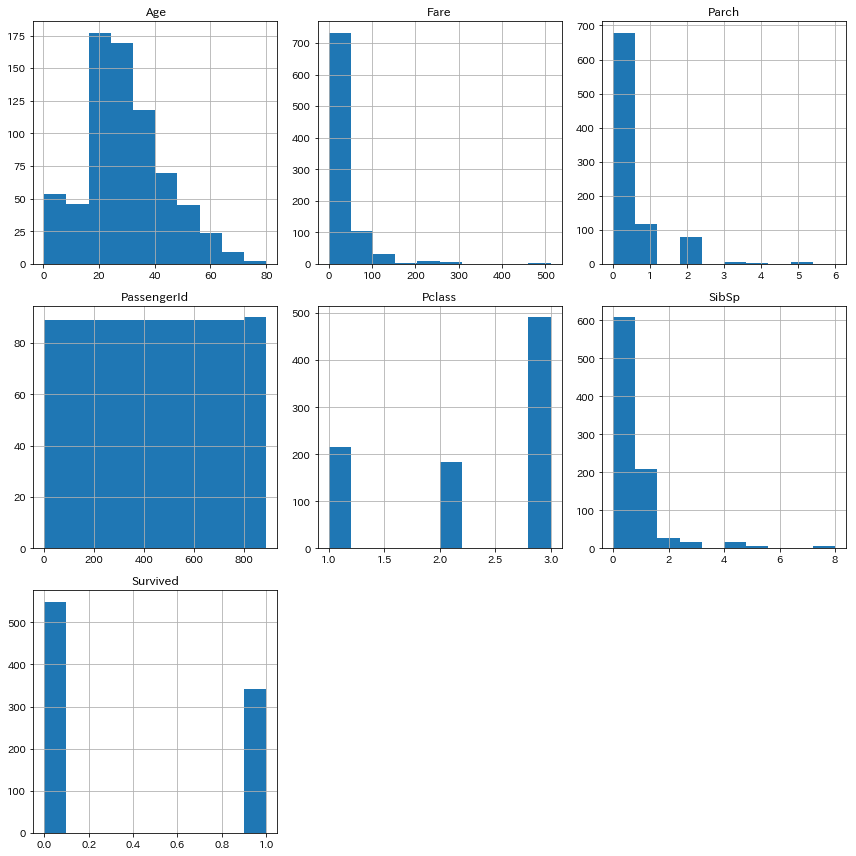

In [18]:
# 訓練データ
train_df.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

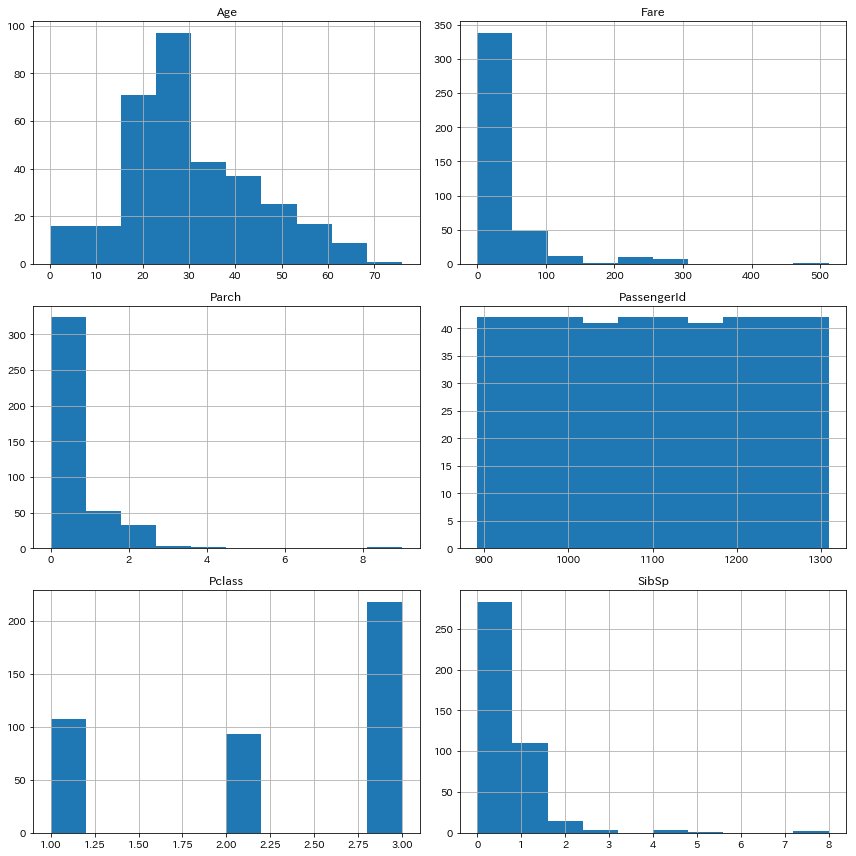

In [19]:
# 評価データ
test_df.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

In [20]:
# 訓練データ、評価データの分布は似ているので、以降は評価データの可視化は省略する。

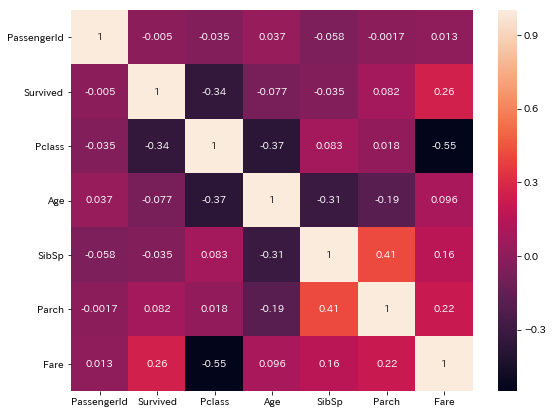

In [21]:
plt.figure(figsize=(9, 7)) 
sns.heatmap(train_df.corr(),annot=True)

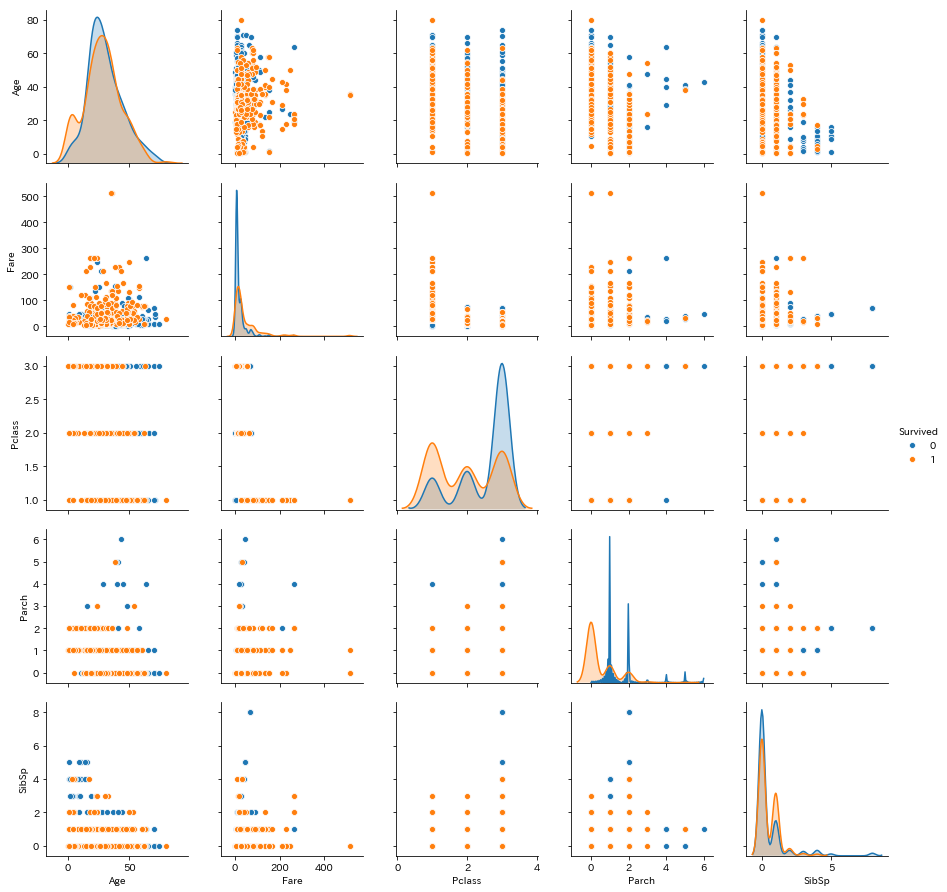

In [22]:
sns.pairplot(data=train_df, hue='Survived', vars=['Age','Fare','Pclass','Parch','SibSp'], diag_kind='auto', kind='scatter')

In [23]:
# 上図の傾向
# (1) 客室グレードが良い方が生存率が良い。
# (2) 配偶者と子供づれでない方が生存率が良い。

#### カテゴリデータの可視化

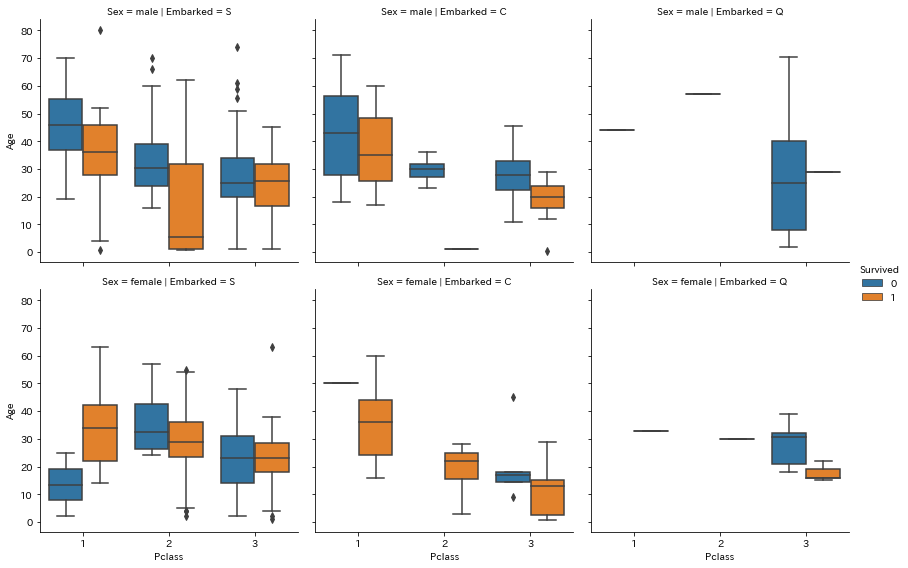

In [24]:
sns.factorplot(x='Pclass',y='Age',hue='Survived',row='Sex',col='Embarked',kind='box', data=train_df, height=4)

In [25]:
# 上図の傾向
# (1) 港「Q」の生存割合は低い。
# (2) 客室グレード「１」、港「S」の生存割合に関して、年齢と性差で逆相関に見える。
#   →年齢、性別、客室グレードも説明変数として有力

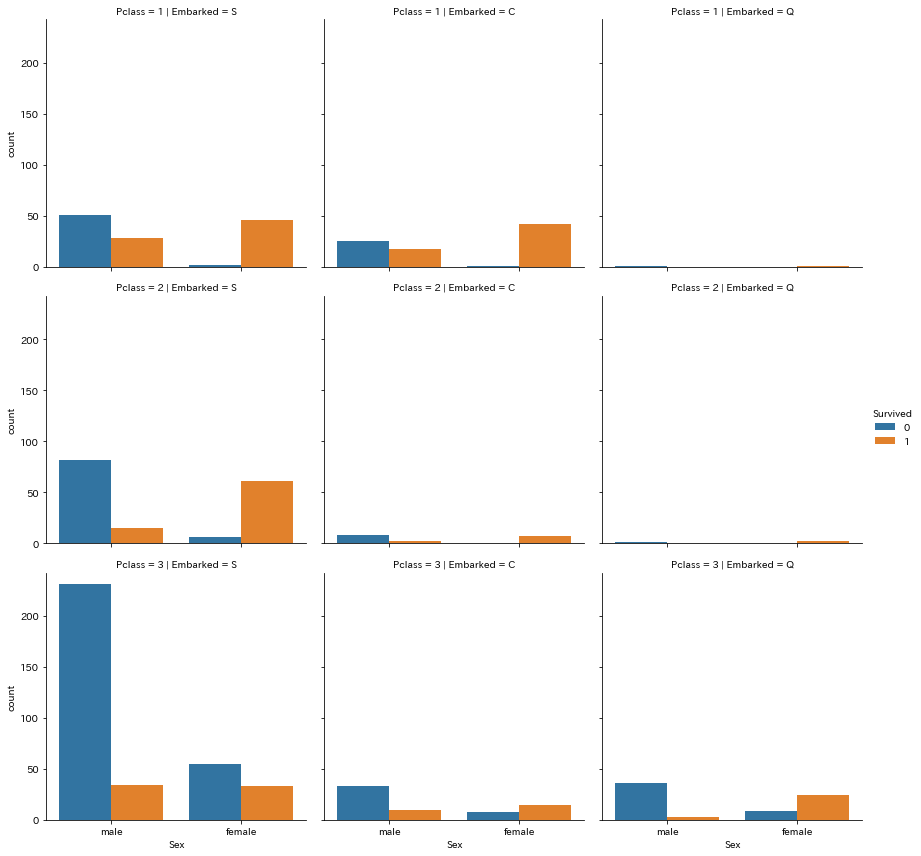

In [26]:
sns.catplot(x='Sex',hue='Survived', row='Pclass', col='Embarked', kind='count', height=4,data=train_df)

In [27]:
# 上図の傾向
# 件数ベースでみた場合、客室グレード「3」、港「S」、男性の死亡件数が相対して高い。

In [28]:
test_df['Pclass'].max()

3

## データ整形

### 欠損値の補間

In [29]:
#【年齢】
# 訓練データの性別毎の平均値で補完する
age_train_mean = train_df.groupby('Sex').Age.mean()
train_df.loc[train_df['Age'].isnull() & (train_df['Sex']=='male'),'Age'] = age_train_mean['male']
train_df.loc[train_df['Age'].isnull() & (train_df['Sex']=='female'),'Age'] = age_train_mean['female']

test_df.loc[test_df['Age'].isnull() & (test_df['Sex']=='male'),'Age'] = age_train_mean['male']
test_df.loc[test_df['Age'].isnull() & (test_df['Sex']=='female'),'Age'] = age_train_mean['female']

In [30]:
#【料金】
# 訓練データの平均値で補完する
test_df.loc[test_df['Fare'].isnull(), 'Fare'] = train_df.Fare.mean()

### 標準化

In [31]:
# 規模の大きい列データを標準化する
sc_train = StandardScaler()
sc_test = StandardScaler()

na_train = sc_train.fit_transform(train_df[['Age','Fare']])
na_test = sc_train.fit_transform(test_df[['Age','Fare']])

df_af_train = pd.DataFrame(na_train, columns=['Age_std','Fare_std'])
df_af_test = pd.DataFrame(na_test, columns=['Age_std','Fare_std'])

train_df = train_df.join([df_af_train])
test_df = test_df.join([df_af_test])

### 二値のカテゴリデータ

In [32]:
#【性別】
# 既存列を"0","1" に置換する
if train_df['Sex'].dtype == 'O':
    train_df['Sex'] = train_df['Sex'].replace(['male','female'],[0,1])

if test_df['Sex'].dtype == 'O':    
    test_df['Sex'] = test_df['Sex'].replace(['male','female'],[0,1])

### 三値以上のカテゴリデータ

In [33]:
# 多重共線対策として最初の列を削除したダミー変数を作成する

pclass_train_df  = pd.get_dummies(train_df['Pclass'] ,prefix='Class', drop_first=True)
pclass_test_df  = pd.get_dummies(test_df['Pclass'], prefix='Class', drop_first=True)

embark_train_df  = pd.get_dummies(train_df['Embarked'].astype(object),prefix='Class', drop_first=True)
embark_test_df  = pd.get_dummies(test_df['Embarked'].astype(object),prefix='Class', drop_first=True)

In [34]:
train_df = train_df.join([pclass_train_df,embark_train_df])
test_df = test_df.join([pclass_test_df,embark_test_df])

### 説明変数の絞り込み

In [35]:
# ダミー変数作成元の変数は不要なので削除する。
train_df.drop(['Pclass','Embarked'],axis=1, inplace=True)
test_df.drop(['Pclass','Embarked'],axis=1, inplace=True)

# 標準化元の変数を削除
train_df.drop(['Age','Fare'],axis=1, inplace=True)
test_df.drop(['Age','Fare'],axis=1, inplace=True)

### 整形後データの確認

In [36]:
train_df.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Sex            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Age_std        891 non-null float64
Fare_std       891 non-null float64
Class_2        891 non-null uint8
Class_3        891 non-null uint8
Class_Q        891 non-null uint8
Class_S        891 non-null uint8
dtypes: float64(2), int64(5), uint8(4)
memory usage: 52.3 KB


In [37]:
test_df.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Sex            418 non-null int64
SibSp          418 non-null int64
Parch          418 non-null int64
Age_std        418 non-null float64
Fare_std       418 non-null float64
Class_2        418 non-null uint8
Class_3        418 non-null uint8
Class_Q        418 non-null uint8
Class_S        418 non-null uint8
dtypes: float64(2), int64(4), uint8(4)
memory usage: 21.3 KB


In [38]:
train_df.head()

,PassengerId,Survived,Sex,SibSp,Parch,Age_std,Fare_std,Class_2,Class_3,Class_Q,Class_S
0,1,0,0,1,0,-0.594732,-0.502445,0,1,0,1
1,2,1,1,1,0,0.635319,0.786845,0,0,0,0
2,3,1,1,0,0,-0.287220,-0.488854,0,1,0,1
3,4,1,1,1,0,0.404684,0.420730,0,0,0,1
4,5,0,0,0,0,0.404684,-0.486337,0,1,0,1


In [39]:
test_df.head()

,PassengerId,Sex,SibSp,Parch,Age_std,Fare_std,Class_2,Class_3,Class_Q,Class_S
0,892,0,0,0,0.340531,-0.498258,0,1,1,0
1,893,1,1,0,1.329961,-0.513125,0,1,0,1
2,894,0,0,0,2.517277,-0.464940,1,0,1,0
3,895,0,0,0,-0.253127,-0.483317,0,1,0,1
4,896,1,1,1,-0.648899,-0.418323,0,1,0,1


## モデル生成・評価・予測

### モデル生成

In [40]:
X = train_df.drop(['PassengerId','Survived'],axis=1)
y = train_df['Survived']

In [41]:
parameters = {
#        'C'      : [0.01, 0.1, 1, 10,  50.0, 60.0, 70.0, 80.0, 100.0, 150.0],
        'C'      : np.logspace(-5,5,100),
        'random_state'      : [0]
}

grid_search = GridSearchCV(
                    LogisticRegression(), 
                    parameters, 
                    cv = 5
                )

grid_search.fit(X.values, y.values)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 1.26186e-05, ..., 7.92483e+04, 1.00000e+05]), 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### モデル評価

In [42]:
# スコアとモデルパラメータのベスト値
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8035914702581369
{'C': 0.06892612104349695, 'random_state': 0}


In [43]:
# 説明変数の重みづけ値（回帰係数）
print(DataFrame([X.columns, grid_search.best_estimator_.coef_[0]]).T)
print("Intercept = ",grid_search.best_estimator_.intercept_)

          0          1
0       Sex    1.73784
1     SibSp  -0.250904
2     Parch -0.0403562
3   Age_std  -0.327356
4  Fare_std    0.34314
5   Class_2 -0.0869051
6   Class_3  -0.988495
7   Class_Q -0.0220229
8   Class_S  -0.382676
Intercept =  [-0.1706235]


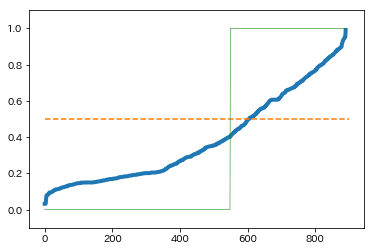

In [44]:
# モデルの当てはまり具合の見える化
def sigmoid(x):
    return 1 / (1+np.exp(-x))

X_value=grid_search.best_estimator_.decision_function(X.values)

#グラフ作成
plt.plot(np.sort(sigmoid(X_value)), lw='4')
plt.plot([0,900],[0.5, 0.5], linestyle='dashed')
plt.plot(np.sort(y), color='green', lw='0.5')
plt.ylim(-0.1,1.1)
plt.show()

In [45]:
# 上図から、やや死亡（Y軸が0～0.5）側の予測に偏っている。

### 予測

In [46]:
X1 = test_df.drop(['PassengerId'],axis=1)
test_predict = grid_search.predict(X1.values)

## Kaggleにアップデートするデータ作成

In [47]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived':np.array(test_predict)})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
